In [1]:
#todo KNN imputation if the missing rate is high.
#todo Create new features that may capture underlying patterns (e.g., interaction terms, polynomial features).
#todo create separate file for data preparation

In [2]:
##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from TargetEncoder import TargetEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [3]:
warnings.filterwarnings('ignore')

In [4]:
##
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = None

In [5]:
##
submission = pd.read_csv('data/sample_submission.csv')
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')
print(train.shape)

(750000, 12)


In [6]:
drop_cols = ['id']
target_col = ['Listening_Time_minutes']
cat_cols = ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
num_cols = [col for col in train.columns if col not in drop_cols + cat_cols + target_col]

In [7]:
train.shape

(750000, 12)

In [8]:
X = train.drop(drop_cols + target_col, axis=1)
y = train['Listening_Time_minutes']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Outliers
 

In [10]:
outliers = 'Episode_Length_minutes > 140 or Number_of_Ads > 3'
index_drop = X_train.query(outliers).index
X_train.drop(index_drop, inplace=True)
y_train.drop(index_drop, inplace=True)

# Data Cleaning and Preprocessing
 

In [11]:
def target_encoder(df_train, df_test, cols, enc):
    for col in cols:
        df_train.loc[:, col] = enc.fit_transform(df_train.loc[:, col], y_train).reshape(-1)
        df_test.loc[:, col] = enc.transform(df_test.loc[:, col]).reshape(-1)
    df_train[cols] = df_train[cols].apply(pd.to_numeric, errors='coerce')
    df_test[cols] = df_test[cols].apply(pd.to_numeric, errors='coerce')

    return df_train, df_test

In [12]:
enc = TargetEncoder()
X_train, X_test = target_encoder(X_train, X_test, ['Podcast_Name', 'Episode_Title'], enc)

In [32]:
numer_type_cols = X_train.select_dtypes(include=["number"]).columns
cat_type_cols = X_train.select_dtypes(include=["object"]).columns

AttributeError: 'numpy.ndarray' object has no attribute 'select_dtypes'

In [30]:
def pipe(numer_type_cols, cat_type_cols):
    
    # Define transformers
    num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),  # Mean imputation
        ("scaler", StandardScaler())  # Standard scaling
    ])
    
    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])
    
    # Combine preprocessing pipelines
    preprocessor = ColumnTransformer([
        ("num", num_pipeline, numer_type_cols),
        ("cat", cat_pipeline, cat_type_cols)
    ])
    return preprocessor


In [31]:
preprocessor = pipe(numer_type_cols, cat_type_cols)

# Baseline Model:

In [14]:
# Define full pipeline with Linear Regression
baseline_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(random_state=42))
])

In [15]:
# Perform Cross-Validation (5-fold)
cv_rmse = np.sqrt(-cross_val_score(baseline_pipeline, X_train, y_train,
                                   scoring="neg_mean_squared_error", cv=5, n_jobs=-1, verbose=100))

# Train on full training set
baseline_pipeline.fit(X_train, y_train)

# Make predictions on test set
y_pred = baseline_pipeline.predict(X_test)

# Calculate RMSE on test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print Results
print(f"Cross-Validation RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
print(f"Test Set RMSE: {test_rmse:.4f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.6s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.6s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished
Cross-Validation RMSE: 13.0489 ± 0.0211
Test Set RMSE: 13.0013


# Final model for submission

In [16]:
outliers = 'Episode_Length_minutes > 140 or Number_of_Ads > 3'
index_drop = X.query(outliers).index
X.drop(index_drop, inplace=True)
y.drop(index_drop, inplace=True)

In [17]:
enc = TargetEncoder()
X, X_test = target_encoder(X, test, ['Podcast_Name', 'Episode_Title'], enc)

In [18]:
baseline_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Host_Popularity_percentage', 'Guest_Popularity_percentage',
       'Number_of_Ads'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [19]:
# Make predictions on test set
submission['Listening_Time_minutes'] = baseline_pipeline.predict(X_test)


In [20]:
submission.to_csv('submission.csv', index=False)

# Feature importances

In [21]:
def plot_importance(importance_df, title="Feature Importance"):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="viridis")
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

In [33]:
model = baseline_pipeline.named_steps['model']
not_transformed = baseline_pipeline.named_steps['preprocessor'].transformers_[0][2]
transformed_columns = baseline_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps[
    'encoder'].get_feature_names_out(input_features=X[cat_type_cols].columns)
all_cols = np.concatenate([not_transformed, transformed_columns])

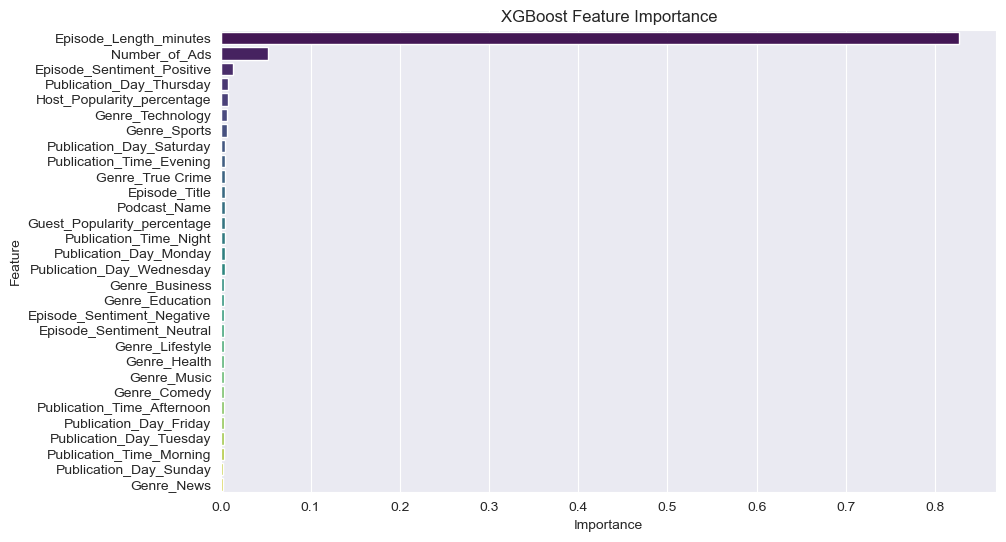

In [22]:
xgb_importance = pd.DataFrame({
    "Feature": all_cols,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)
plot_importance(xgb_importance, "XGBoost Feature Importance")

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

enc = TargetEncoder()
X_train, X_test = target_encoder(X_train, X_test, ['Podcast_Name', 'Episode_Title'], enc)
preprocessor = pipe(numer_type_cols, cat_type_cols)
X_train = preprocessor.fit_transform(X_train)


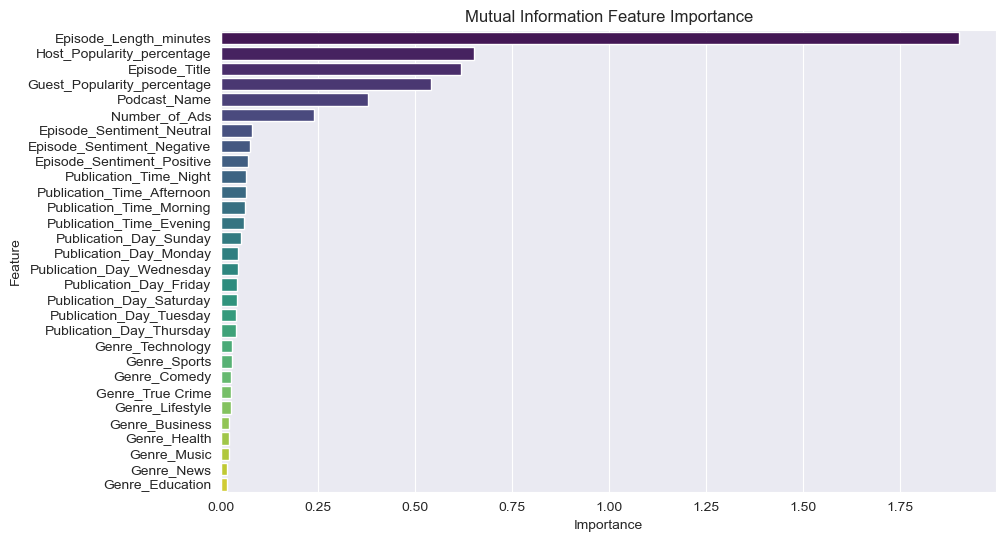

In [28]:
# 📌 4️⃣ Statistical Test - Mutual Information
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X_train, y_train)
mi_importance = pd.DataFrame({
    "Feature": all_cols,
    "Importance": mi_scores
}).sort_values(by="Importance", ascending=False)
plot_importance(mi_importance, "Mutual Information Feature Importance")

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

enc = TargetEncoder()
X_train, X_test = target_encoder(X_train, X_test, ['Podcast_Name', 'Episode_Title'], enc)
preprocessor = pipe(numer_type_cols, cat_type_cols)
X_train = preprocessor.fit_transform(X_train)


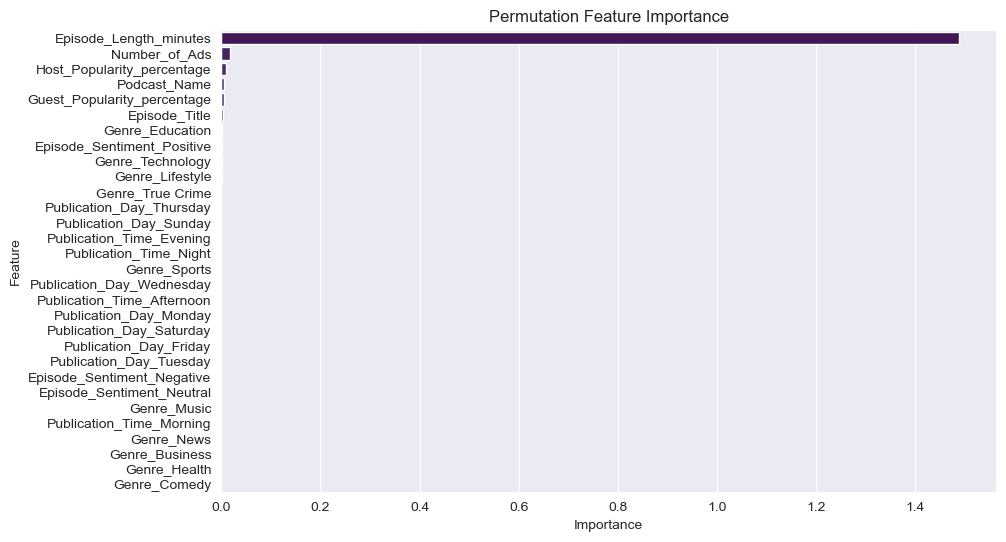

In [35]:
# 📌 5️⃣ Permutation Importance (Shuffling Feature Values)
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)
perm_importance_df = pd.DataFrame({
    "Feature": all_cols,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)
plot_importance(perm_importance_df, "Permutation Feature Importance")